## Polynomial Linear Regression

## Importing Libraries

In [1]:
import sys
import os

current_dir = os.getcwd() 
code_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))

if code_dir not in sys.path:
    sys.path.append(code_dir)

from src.models.linear_models import LinearRegression
from src.loss_functions.regression_losses import MeanSquaredError, MeanAbsoluteError
from src.optimisers.gradient_based import BatchGradientDescent, StochasticGradientDescent, MiniBatchGradientDescent
from src.optimisers.cellular_automata import CellularAutomataOptimiser
from src.utils import configurations

import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as SK_LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Loading the dataset

In [2]:
df = pd.read_csv("../datasets/polynomial_regression_data.csv")
X = df.drop("target", axis=1)
y = df["target"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=configurations.TEST_SIZE, random_state=configurations.SEED)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

degree = 3

poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

In [4]:
n_features = X_train_poly.shape[1]

In [5]:
X_train = X_train_poly
X_test = X_test_poly

In [6]:
RUNS = 10

loss_functions = {
    'Mean Squared Error': MeanSquaredError(),
    'Mean Absolute Error': MeanAbsoluteError()
}
optimisers = {
    'Batch Gradient Descent': BatchGradientDescent(0.01),
    'Stochastic Gradient Descent': StochasticGradientDescent(0.01),
    'Mini Batch Gradient Descent': MiniBatchGradientDescent(0.01),
    'Cellular Automata Optimiser': CellularAutomataOptimiser(L=5, mu=0.01, omega=0.8)
}

In [7]:
final_aggregated_results = []
PLOTTING_CURVES_MSE = {}
PLOTTING_CURVES_MAE = {}
MAX_ITERS = 1000

In [8]:
print('==================== CONFIGURATIONS ====================')
print(f"MAX_ITERS={configurations.MAX_ITERS}, TEST_SIZE={configurations.TEST_SIZE}, ALPHA={configurations.ALPHA}")
print('='*56)

==================== CONFIGURATIONS ====================
MAX_ITERS=1000, TEST_SIZE=0.2, ALPHA=0.01


In [9]:
# use one optimiser at a time
for optimiser_name, optimiser in optimisers.items():
    # use one loss function at a time
    for loss_name, loss_func in loss_functions.items():
        print('='*75)
        print(f'Running Combination: {optimiser_name} / {loss_name}')

        # metric used for evaluation
        train_losses_for_avg = []
        r2_score_for_avg = []
        test_mse_for_avg = []
        test_mae_for_avg = [] 
        run_times_for_avg = []
        loss_per_iterations = []

        # test every optimiser for 10 runs
        for i in range(RUNS):
            model = LinearRegression(n_features=n_features)

            # calculating the time for each run
            start_time = time.time()
            optimiser_results = optimiser.optimise(model, loss_func, X_train, y_train, max_iters=MAX_ITERS) 
            run_time = time.time() - start_time

            model.set_params(optimiser_results['parameters'])
            y_pred = model.predict(X_test)

            test_mse = mean_squared_error(y_test, y_pred)
            test_mae = mean_absolute_error(y_test, y_pred)
            
            train_losses_for_avg.append(optimiser_results['best_loss'])
            test_mse_for_avg.append(test_mse)
            test_mae_for_avg.append(test_mae)
            r2_score_for_avg.append(r2_score(y_test, y_pred))
            run_times_for_avg.append(run_time)
            loss_per_iterations.append(optimiser_results['loss_history']) # this will store all the losses per iteration from 1 to 1000
            

        train_losses_array = np.array(train_losses_for_avg)
        test_mse_array = np.array(test_mse_for_avg)
        test_mae_array = np.array(test_mae_for_avg)
        r2_score_array = np.array(r2_score_for_avg)
        run_times_array = np.array(run_times_for_avg)
        loss_per_iterations_array = np.array(loss_per_iterations)

        avg_train_loss = np.mean(train_losses_array)
        std_dev_train_loss = np.std(train_losses_array)
        avg_test_mse = np.mean(test_mse_array)
        std_dev_test_mse = np.std(test_mse_array)
        avg_test_mae = np.mean(test_mae_array)
        std_dev_test_mae = np.std(test_mae_array)
        avg_r2_score = np.mean(r2_score_array)
        std_dev_r2_score = np.std(r2_score_array)
        avg_time = np.mean(run_times_array)
        std_dev_time = np.std(run_times_array)
        avg_loss_per_iter = np.mean(loss_per_iterations_array, axis=0)

        if loss_name == 'Mean Squared Error':
            PLOTTING_CURVES_MSE[optimiser_name] = avg_loss_per_iter
            print(f"-> Stored average MSE curve for {optimiser_name}.")
        elif loss_name == 'Mean Absolute Error':
            PLOTTING_CURVES_MAE[optimiser_name] = avg_loss_per_iter
            print(f"-> Stored average MAE curve for {optimiser_name}.")

        final_aggregated_results.append({
        'Optimiser': optimiser_name,
        'Loss_Function': loss_name,
        'Avg_Train_Loss': avg_train_loss,
        'Std_Dev_Train_Loss': std_dev_train_loss,
        'Avg_Test_MSE': avg_test_mse,
        'Std_Dev_Test_MSE': std_dev_test_mse,
        'Avg_Test_MAE': avg_test_mae,
        'Std_Dev_Test_MAE': std_dev_test_mae,
        'Avg_R2_Score': avg_r2_score,
        'Std_Dev_R2_Score': std_dev_r2_score,
        'Avg_Time_s': avg_time,
        'Std_Dev_Time_s': std_dev_time
        })

Running Combination: Batch Gradient Descent / Mean Squared Error
-> Stored average MSE curve for Batch Gradient Descent.
Running Combination: Batch Gradient Descent / Mean Absolute Error
-> Stored average MAE curve for Batch Gradient Descent.
Running Combination: Stochastic Gradient Descent / Mean Squared Error
-> Stored average MSE curve for Stochastic Gradient Descent.
Running Combination: Stochastic Gradient Descent / Mean Absolute Error
-> Stored average MAE curve for Stochastic Gradient Descent.
Running Combination: Mini Batch Gradient Descent / Mean Squared Error
-> Stored average MSE curve for Mini Batch Gradient Descent.
Running Combination: Mini Batch Gradient Descent / Mean Absolute Error
-> Stored average MAE curve for Mini Batch Gradient Descent.
Running Combination: Cellular Automata Optimiser / Mean Squared Error
-> Stored average MSE curve for Cellular Automata Optimiser.
Running Combination: Cellular Automata Optimiser / Mean Absolute Error
-> Stored average MAE curve f

In [10]:
results_df = pd.DataFrame(final_aggregated_results)

output_folder = "tables"
file_name = "PLR_results.csv"
output_path = os.path.join(output_folder, file_name)

results_df.to_csv(output_path, index=False)
print(f"Successfully saved results to: {output_path}")

Successfully saved results to: tables\PLR_results.csv


In [11]:
results_df

,Optimiser,Loss_Function,Avg_Train_Loss,Std_Dev_Train_Loss,Avg_Test_MSE,Std_Dev_Test_MSE,Avg_Test_MAE,Std_Dev_Test_MAE,Avg_R2_Score,Std_Dev_R2_Score,Avg_Time_s,Std_Dev_Time_s
0,Batch Gradient Descent,Mean Squared Error,12827.747141,6033.036260,2.903497e+04,1.505940e+04,130.250823,33.079849,-3.698982,2.437193,0.014713,0.000518
1,Batch Gradient Descent,Mean Absolute Error,3020.483255,234.306917,1.205623e+07,3.252531e+06,2573.497673,319.238433,-1950.163917,526.385435,0.015314,0.001379
2,Stochastic Gradient Descent,Mean Squared Error,22.934755,10.261967,2.571511e+01,8.198638e+00,3.852189,0.703121,0.995838,0.001327,4.564093,0.799453
3,Stochastic Gradient Descent,Mean Absolute Error,1308.647787,163.623806,4.780041e+06,1.929743e+06,1530.107492,261.205747,-772.595573,312.307163,2.810181,0.041297
4,Mini Batch Gradient Descent,Mean Squared Error,4.937230,2.149644,8.900359e+00,4.572853e+00,2.328585,0.614253,0.998560,0.000740,0.111711,0.003877
5,Mini Batch Gradient Descent,Mean Absolute Error,3139.155446,415.088464,1.654376e+07,6.234914e+06,2986.990253,549.878429,-2676.420280,1009.050303,0.114730,0.003660
6,Cellular Automata Optimiser,Mean Squared Error,56986.549195,15651.187216,1.217685e+05,3.181762e+04,266.271946,32.227384,-18.706853,5.149322,19.302340,0.258684
7,Cellular Automata Optimiser,Mean Absolute Error,205.146732,21.724800,1.843141e+05,6.634036e+04,305.288140,43.747304,-28.829152,10.736438,19.413642,0.720501


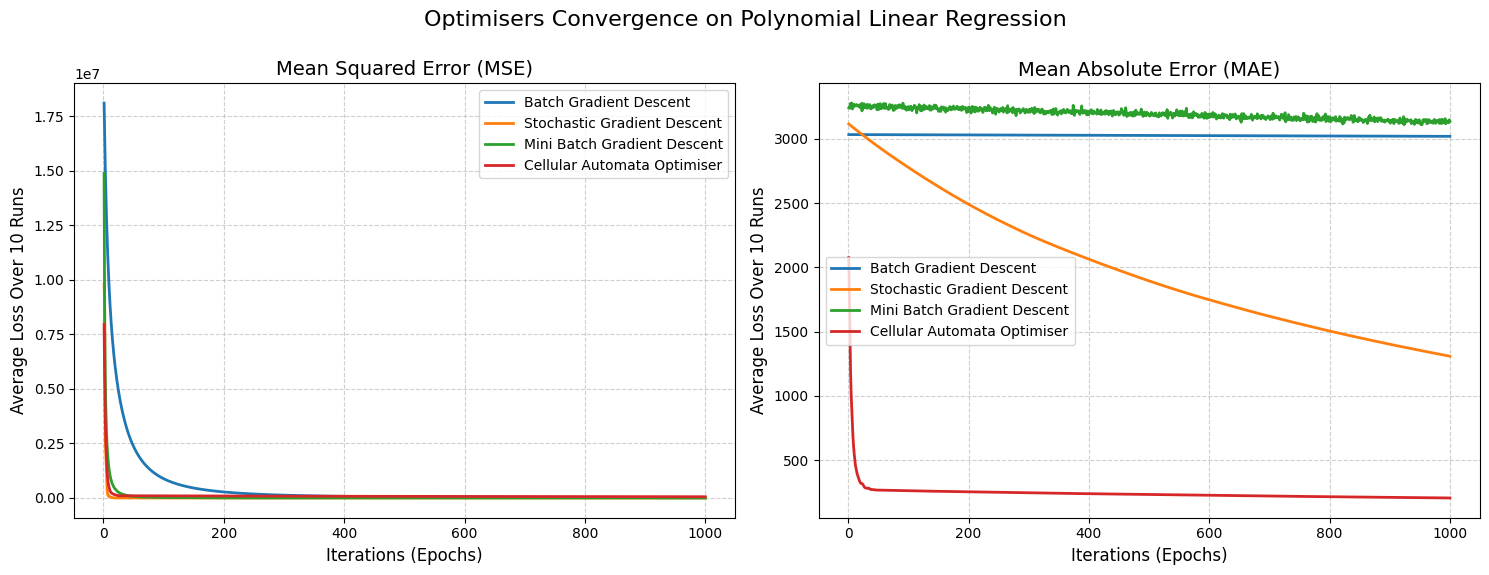

In [12]:
iterations = np.arange(1, MAX_ITERS + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

# for Mean Squared Error
for optimiser_name, avg_curve in PLOTTING_CURVES_MSE.items():
    ax[0].plot(iterations, avg_curve, label=optimiser_name, linewidth=2)

ax[0].set_title('Mean Squared Error (MSE)', fontsize=14)
ax[0].set_xlabel('Iterations (Epochs)', fontsize=12)
ax[0].set_ylabel('Average Loss Over 10 Runs', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()

# for Mean Absolute Error
for optimiser_name, avg_curve in PLOTTING_CURVES_MAE.items():
    ax[1].plot(iterations, avg_curve, label=optimiser_name, linewidth=2)

ax[1].set_title('Mean Absolute Error (MAE)', fontsize=14)
ax[1].set_xlabel('Iterations (Epochs)', fontsize=12)
ax[1].set_ylabel(f'Average Loss Over {RUNS} Runs', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend()

fig.suptitle('Optimisers Convergence on Polynomial Linear Regression', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Polynomial Linear Regression Loss Plot.png')